# Śledzenie eksperymentów i wyszukiwanie hiperparametrów z biblioteką ClearML

# Przygotowanie

Do wykonania zadania potrzebne będzie założenie konta na stronie [clear.ml](https://clear.ml/)

Instalujemy bibliotekę ClearML

In [ ]:
!!pip install clearml numpy clearml-agent 'pyjwt<1.8.0'

['Collecting clearml',
 '  Downloading clearml-1.13.2-py2.py3-none-any.whl (1.1 MB)',
 '\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/1.1 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━\x1b\x1b╺\x1b\x1b━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.4/1.1 MB\x1b \x1b12.7 MB/s\x1b eta \x1b0:00:01\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.1/1.1 MB\x1b \x1b21.0 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25hRequirement already satisfied: numpy in /usr/local/lib/python3.10/dist-packages (1.23.5)',
 'Collecting clearml-agent',
 '  Downloading clearml_agent-1.6.1-py3-none-any.whl (409 kB)',
 '\x1b[?25l     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/409.1 kB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K     \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b409.1/409.1 kB\x1b \x1b41.5 MB/s\x1b eta \x1b0:00:00\x1b',
 '\x1b[?25hCollecting pyjwt<1.8.0',
 '  Downloading PyJWT-1.7.1-py2.py3-none-any.whl (18 kB)',
 'Re

Instalujemy bibliotekę pytorch lightning

In [ ]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 13.7 MB/s eta 0:00:00


Musimy przekazać do biblioteki ClearML dane naszego konta. Można to zrobić nadpisując zmienne systemowe (tak jak poniżej). W przypadku pracy na maszynie lokalnej można to zrobić na stałe przy pomocy komendy `clearml-init`

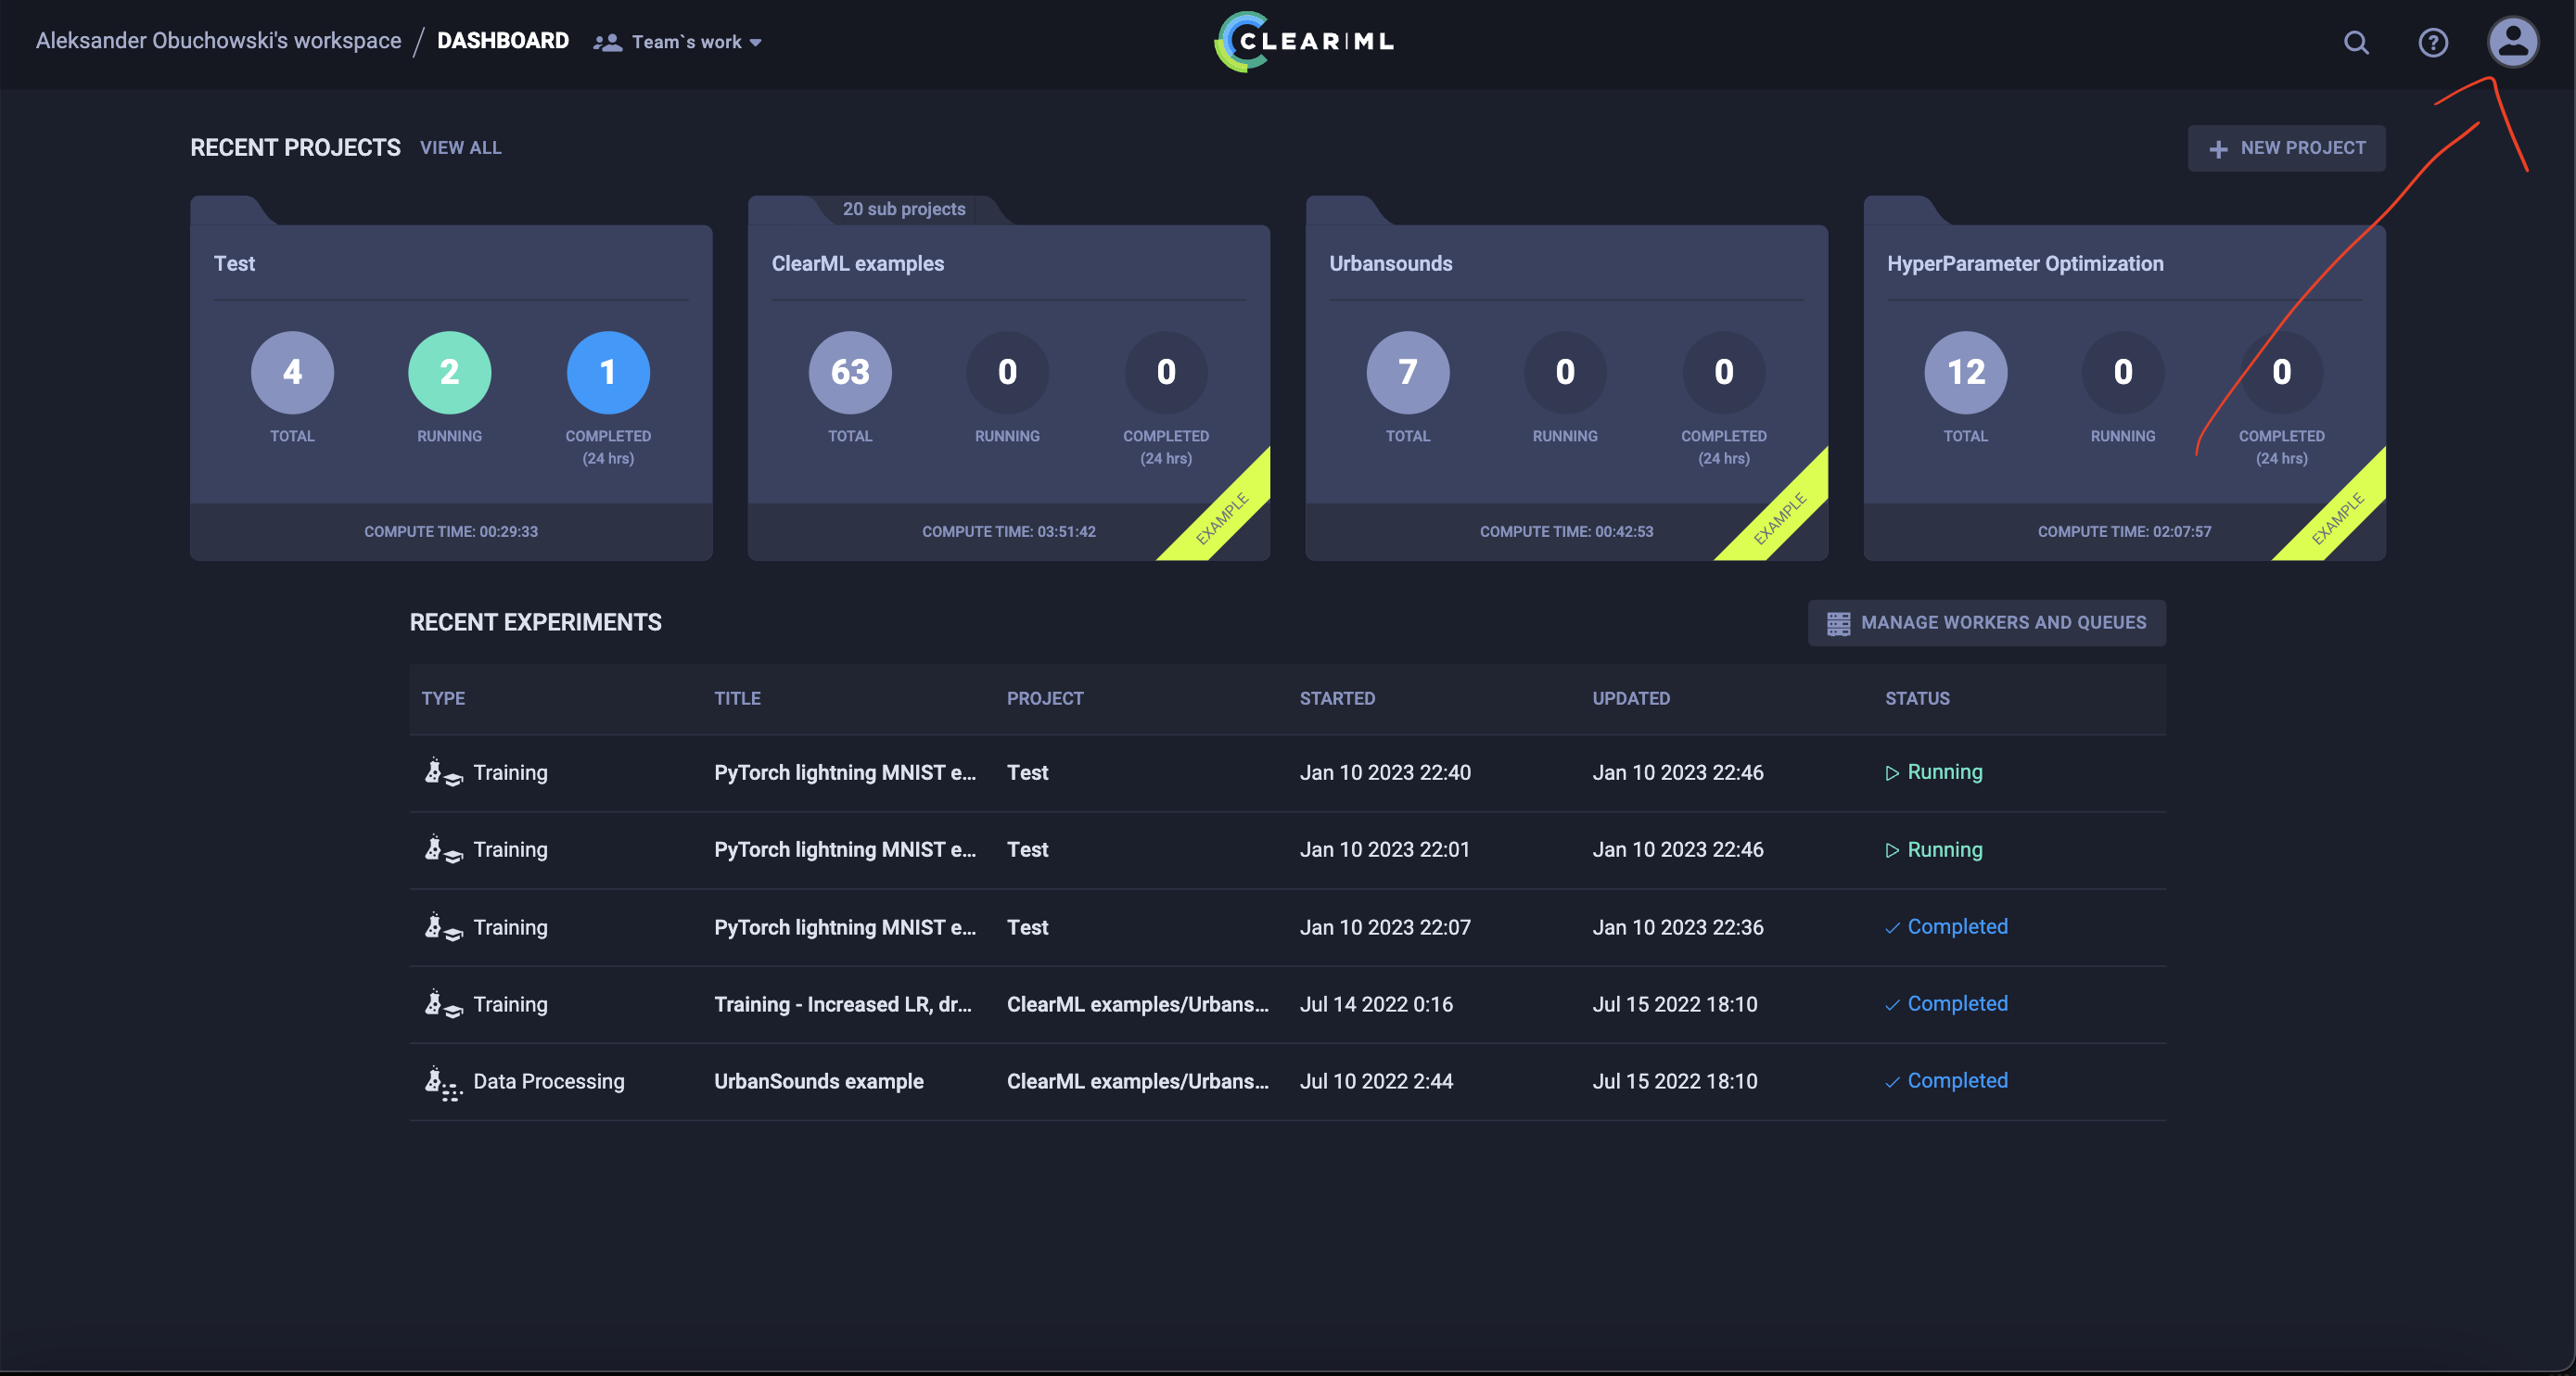

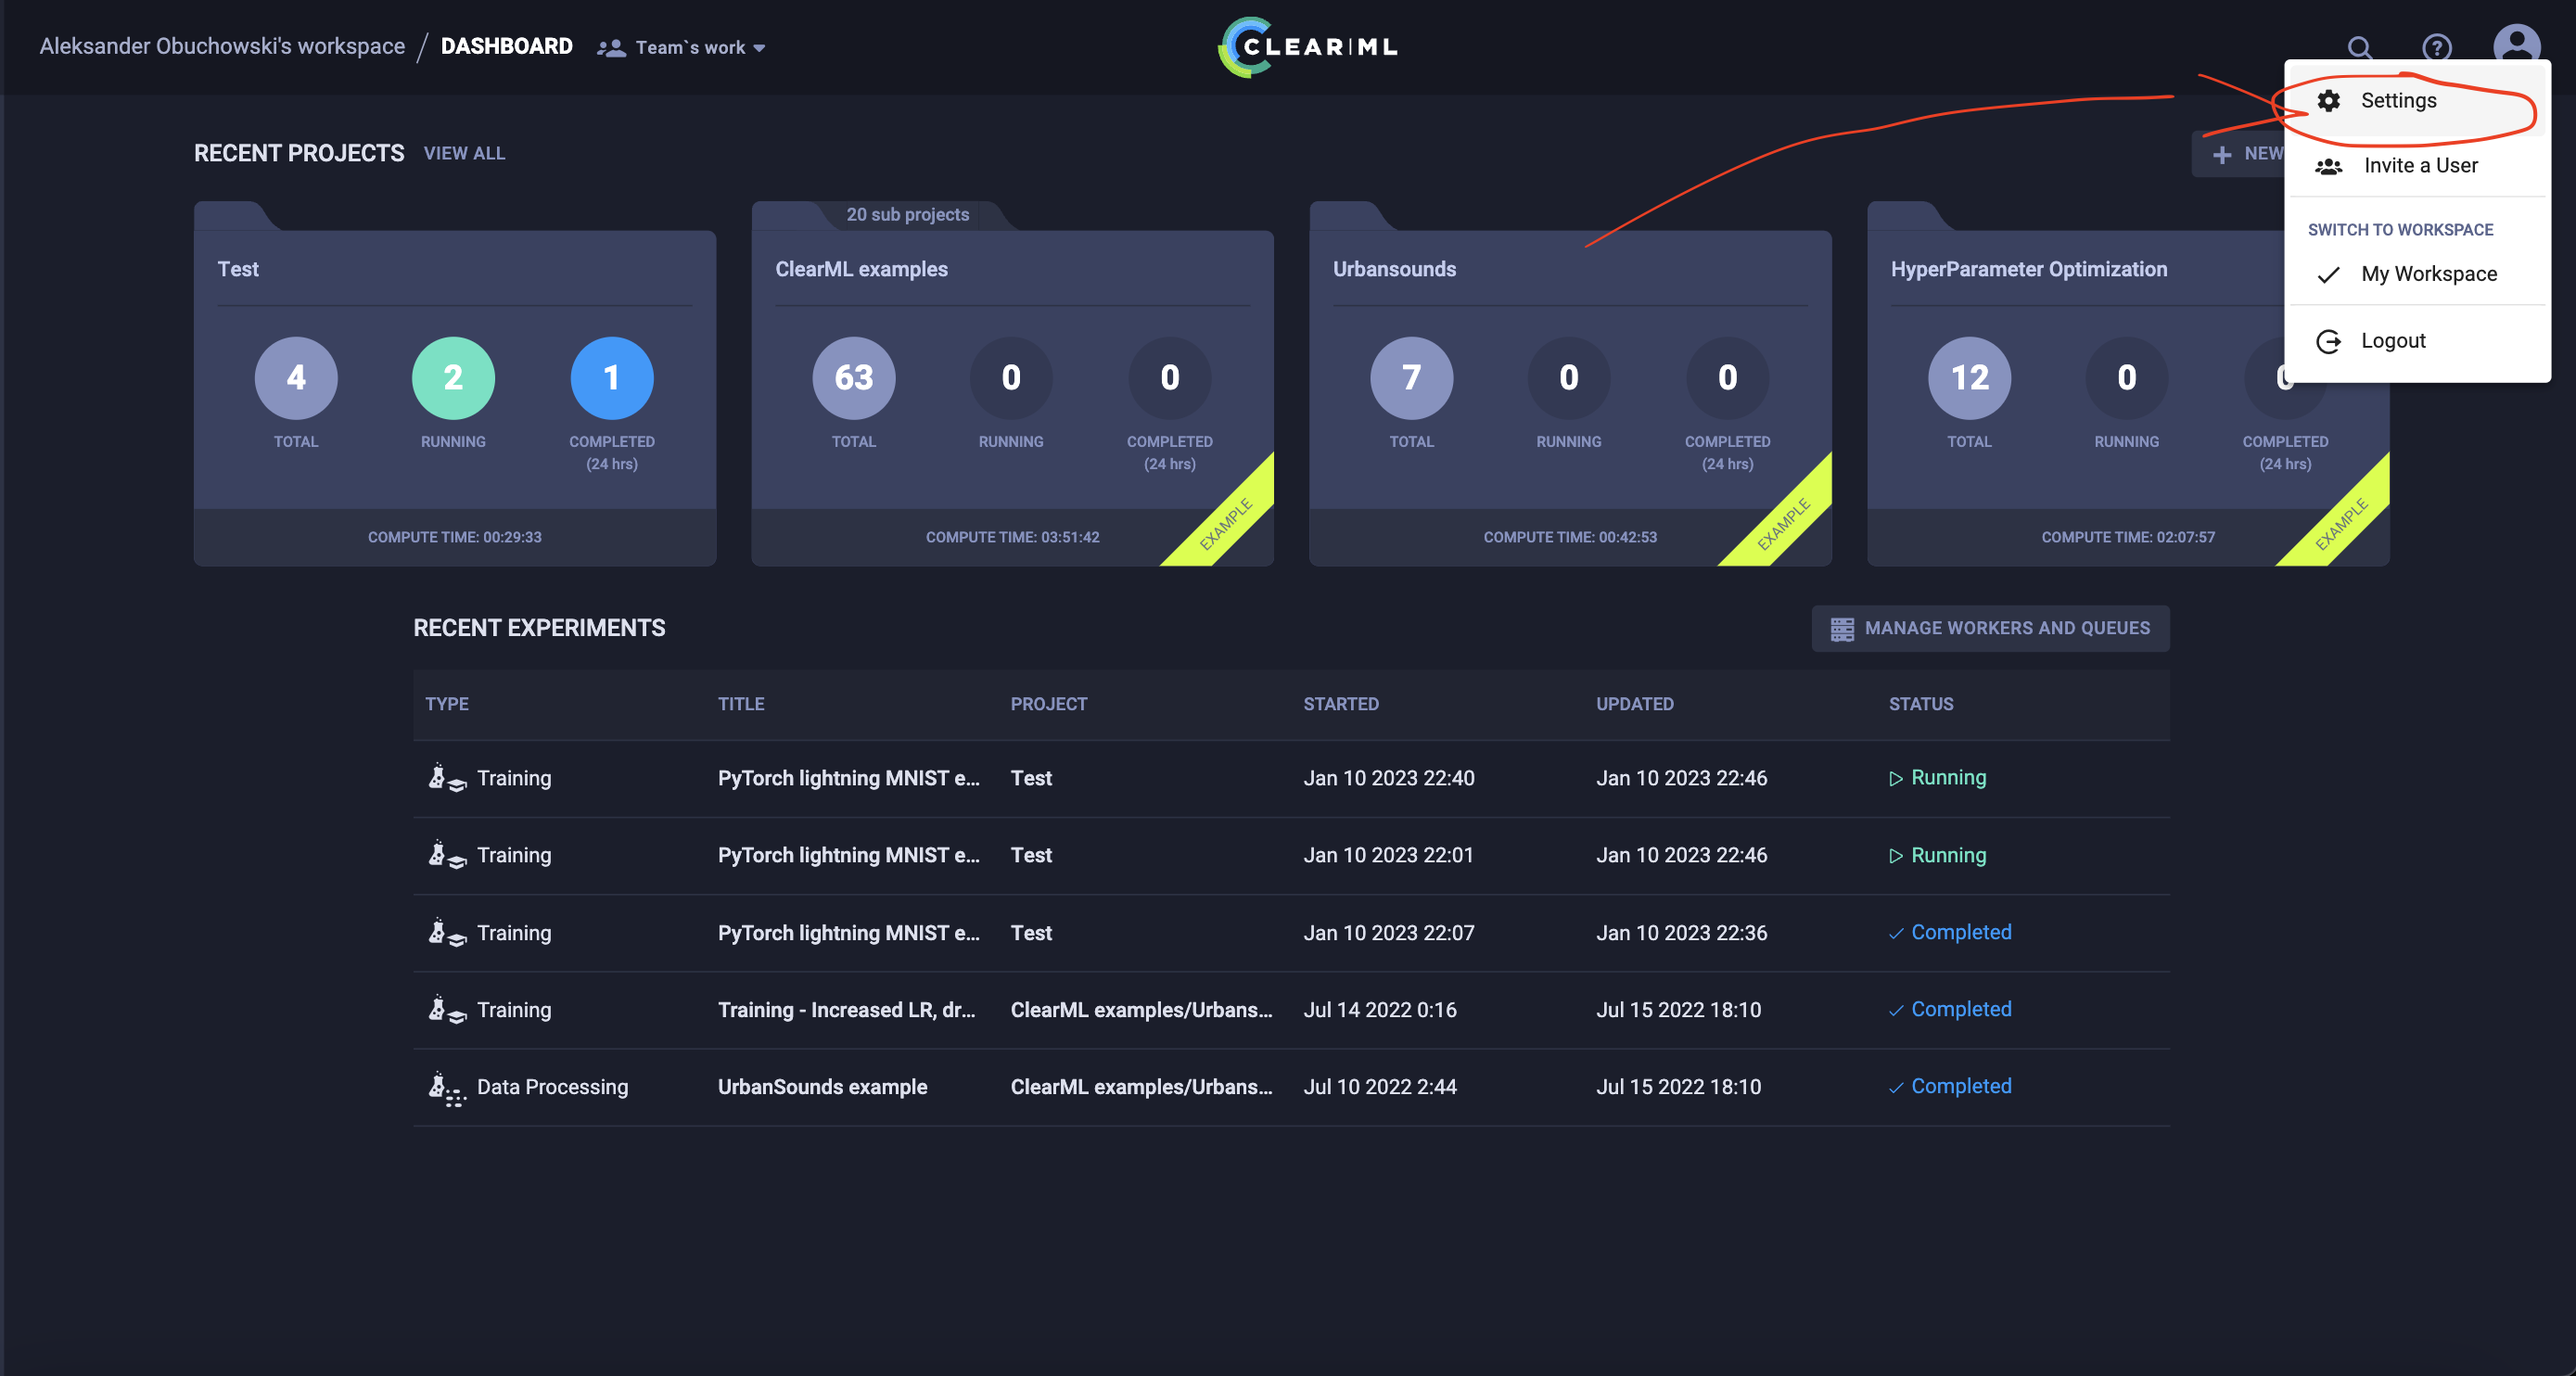

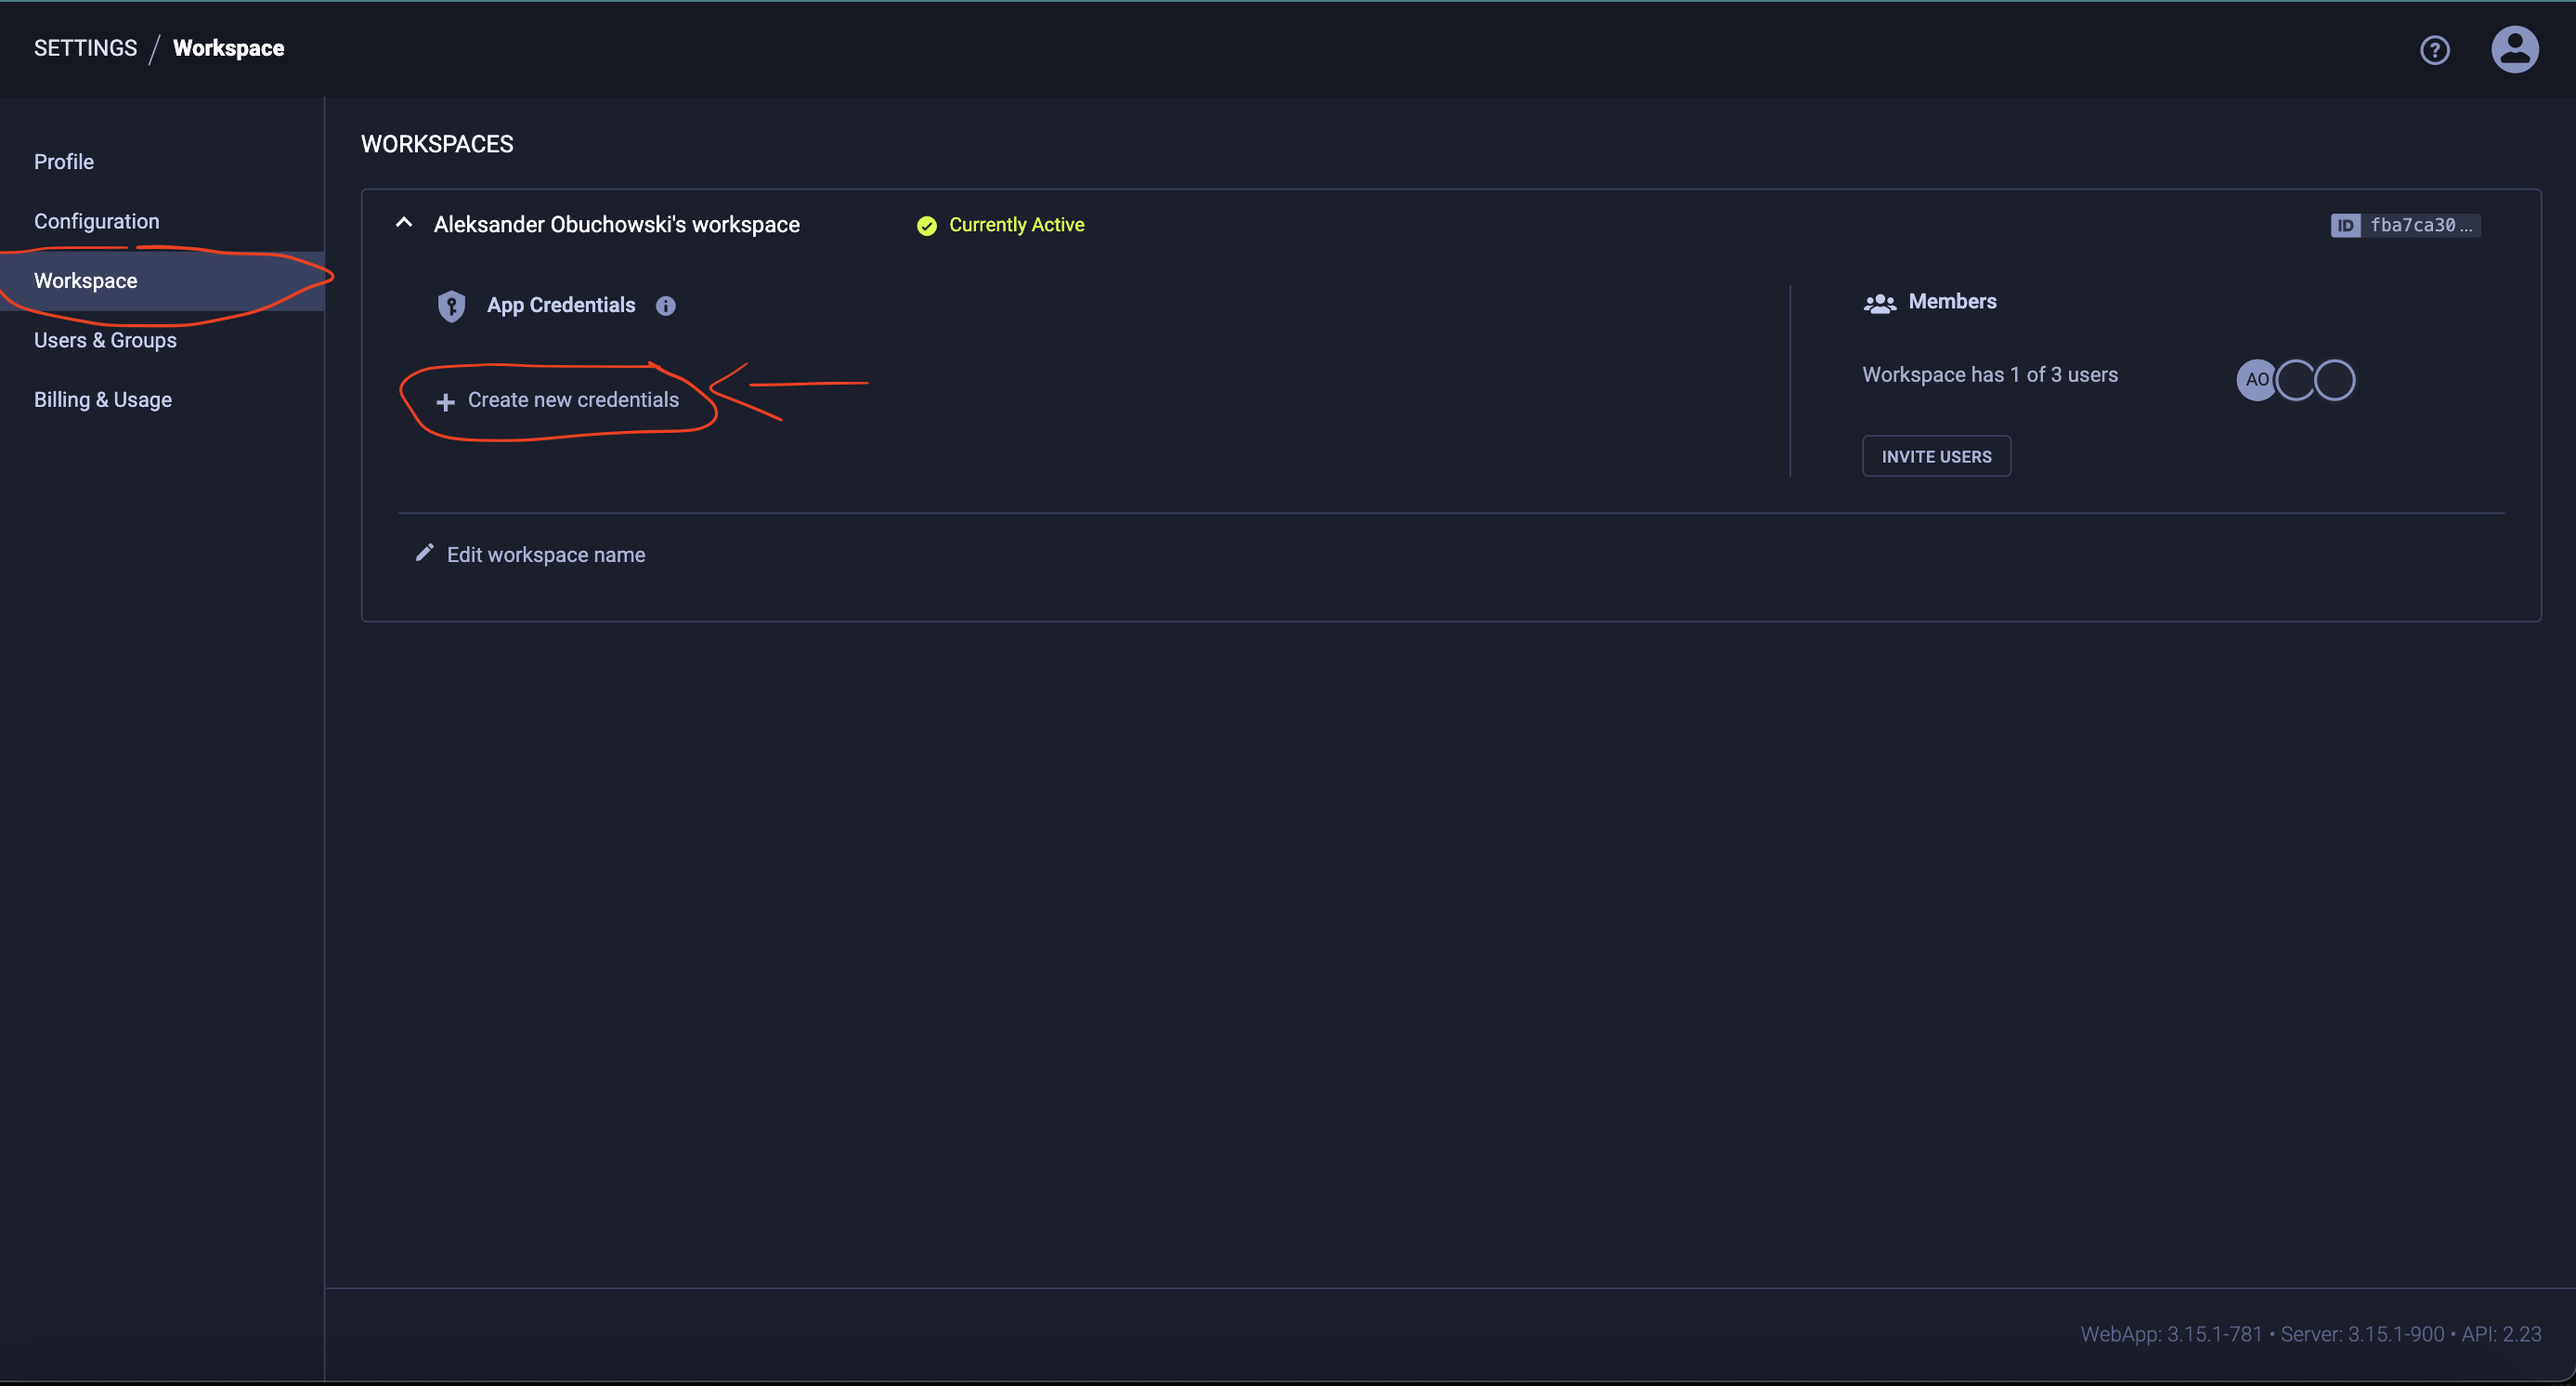

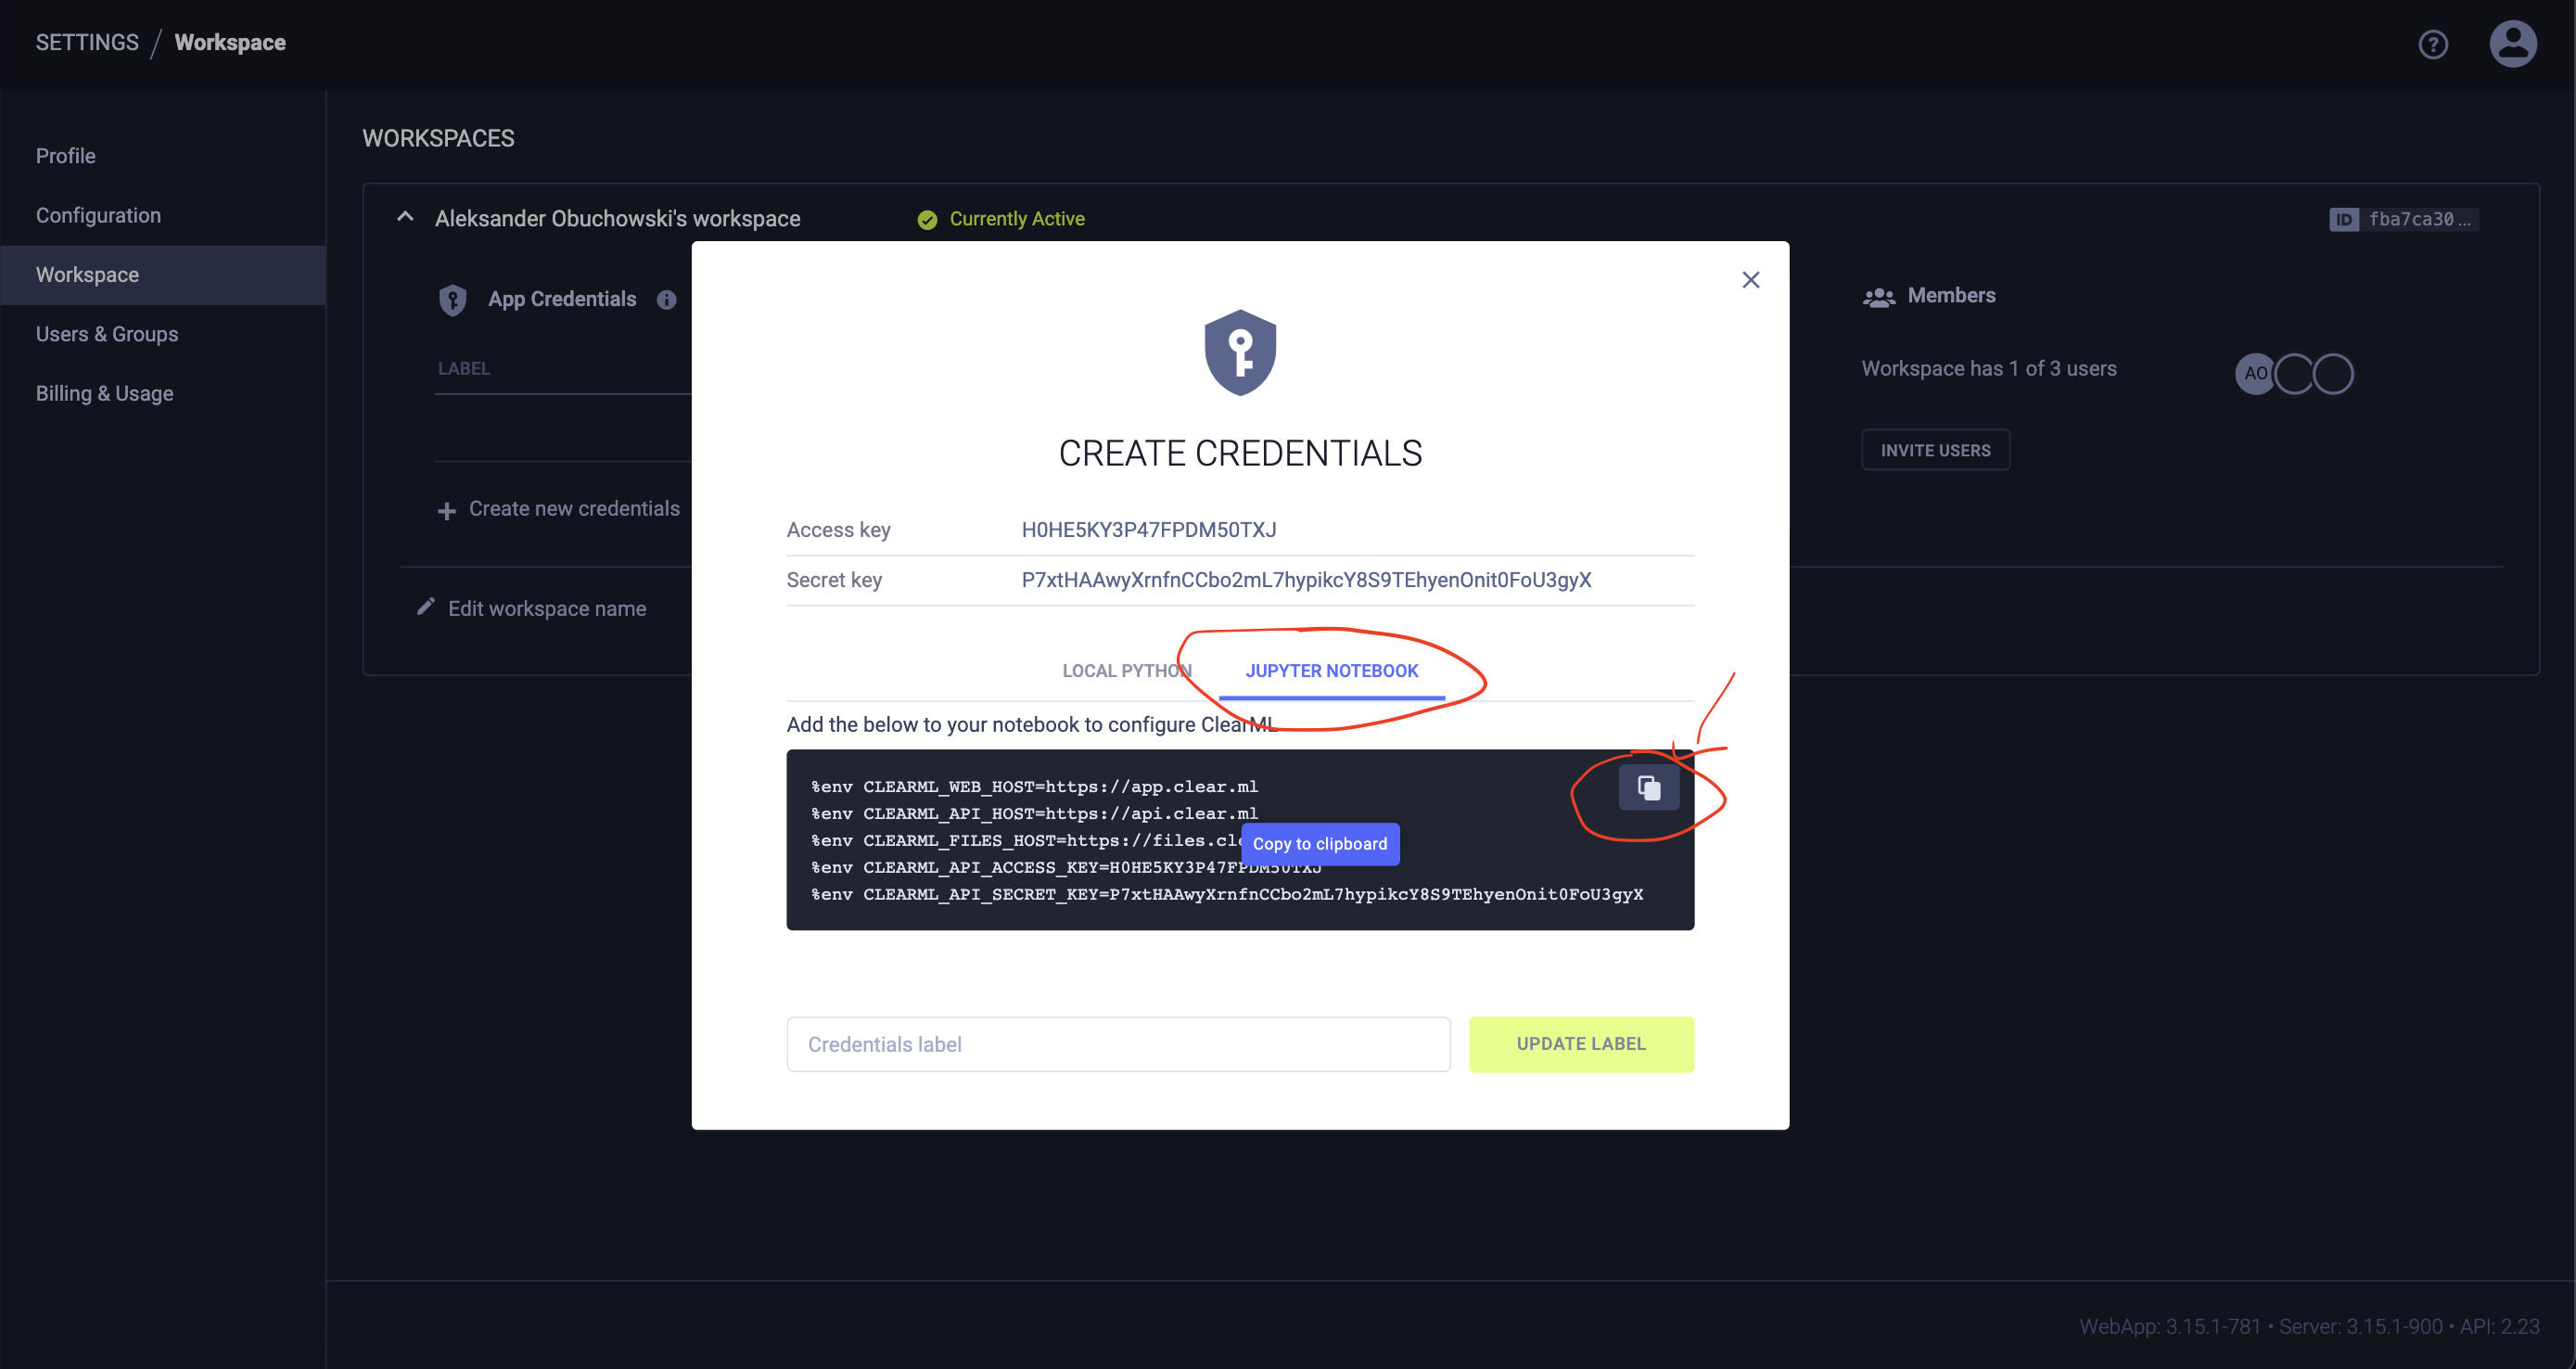

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=X3NXFI7TYZC5KZVJHFIS
%env CLEARML_API_SECRET_KEY=WYcHL6PcavGjdvwPoLoEJFwbWHq7AC4MFdjGWWqX0p4pUxCgEo

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=X3NXFI7TYZC5KZVJHFIS
env: CLEARML_API_SECRET_KEY=WYcHL6PcavGjdvwPoLoEJFwbWHq7AC4MFdjGWWqX0p4pUxCgEo


Tworzymy nowy projekt

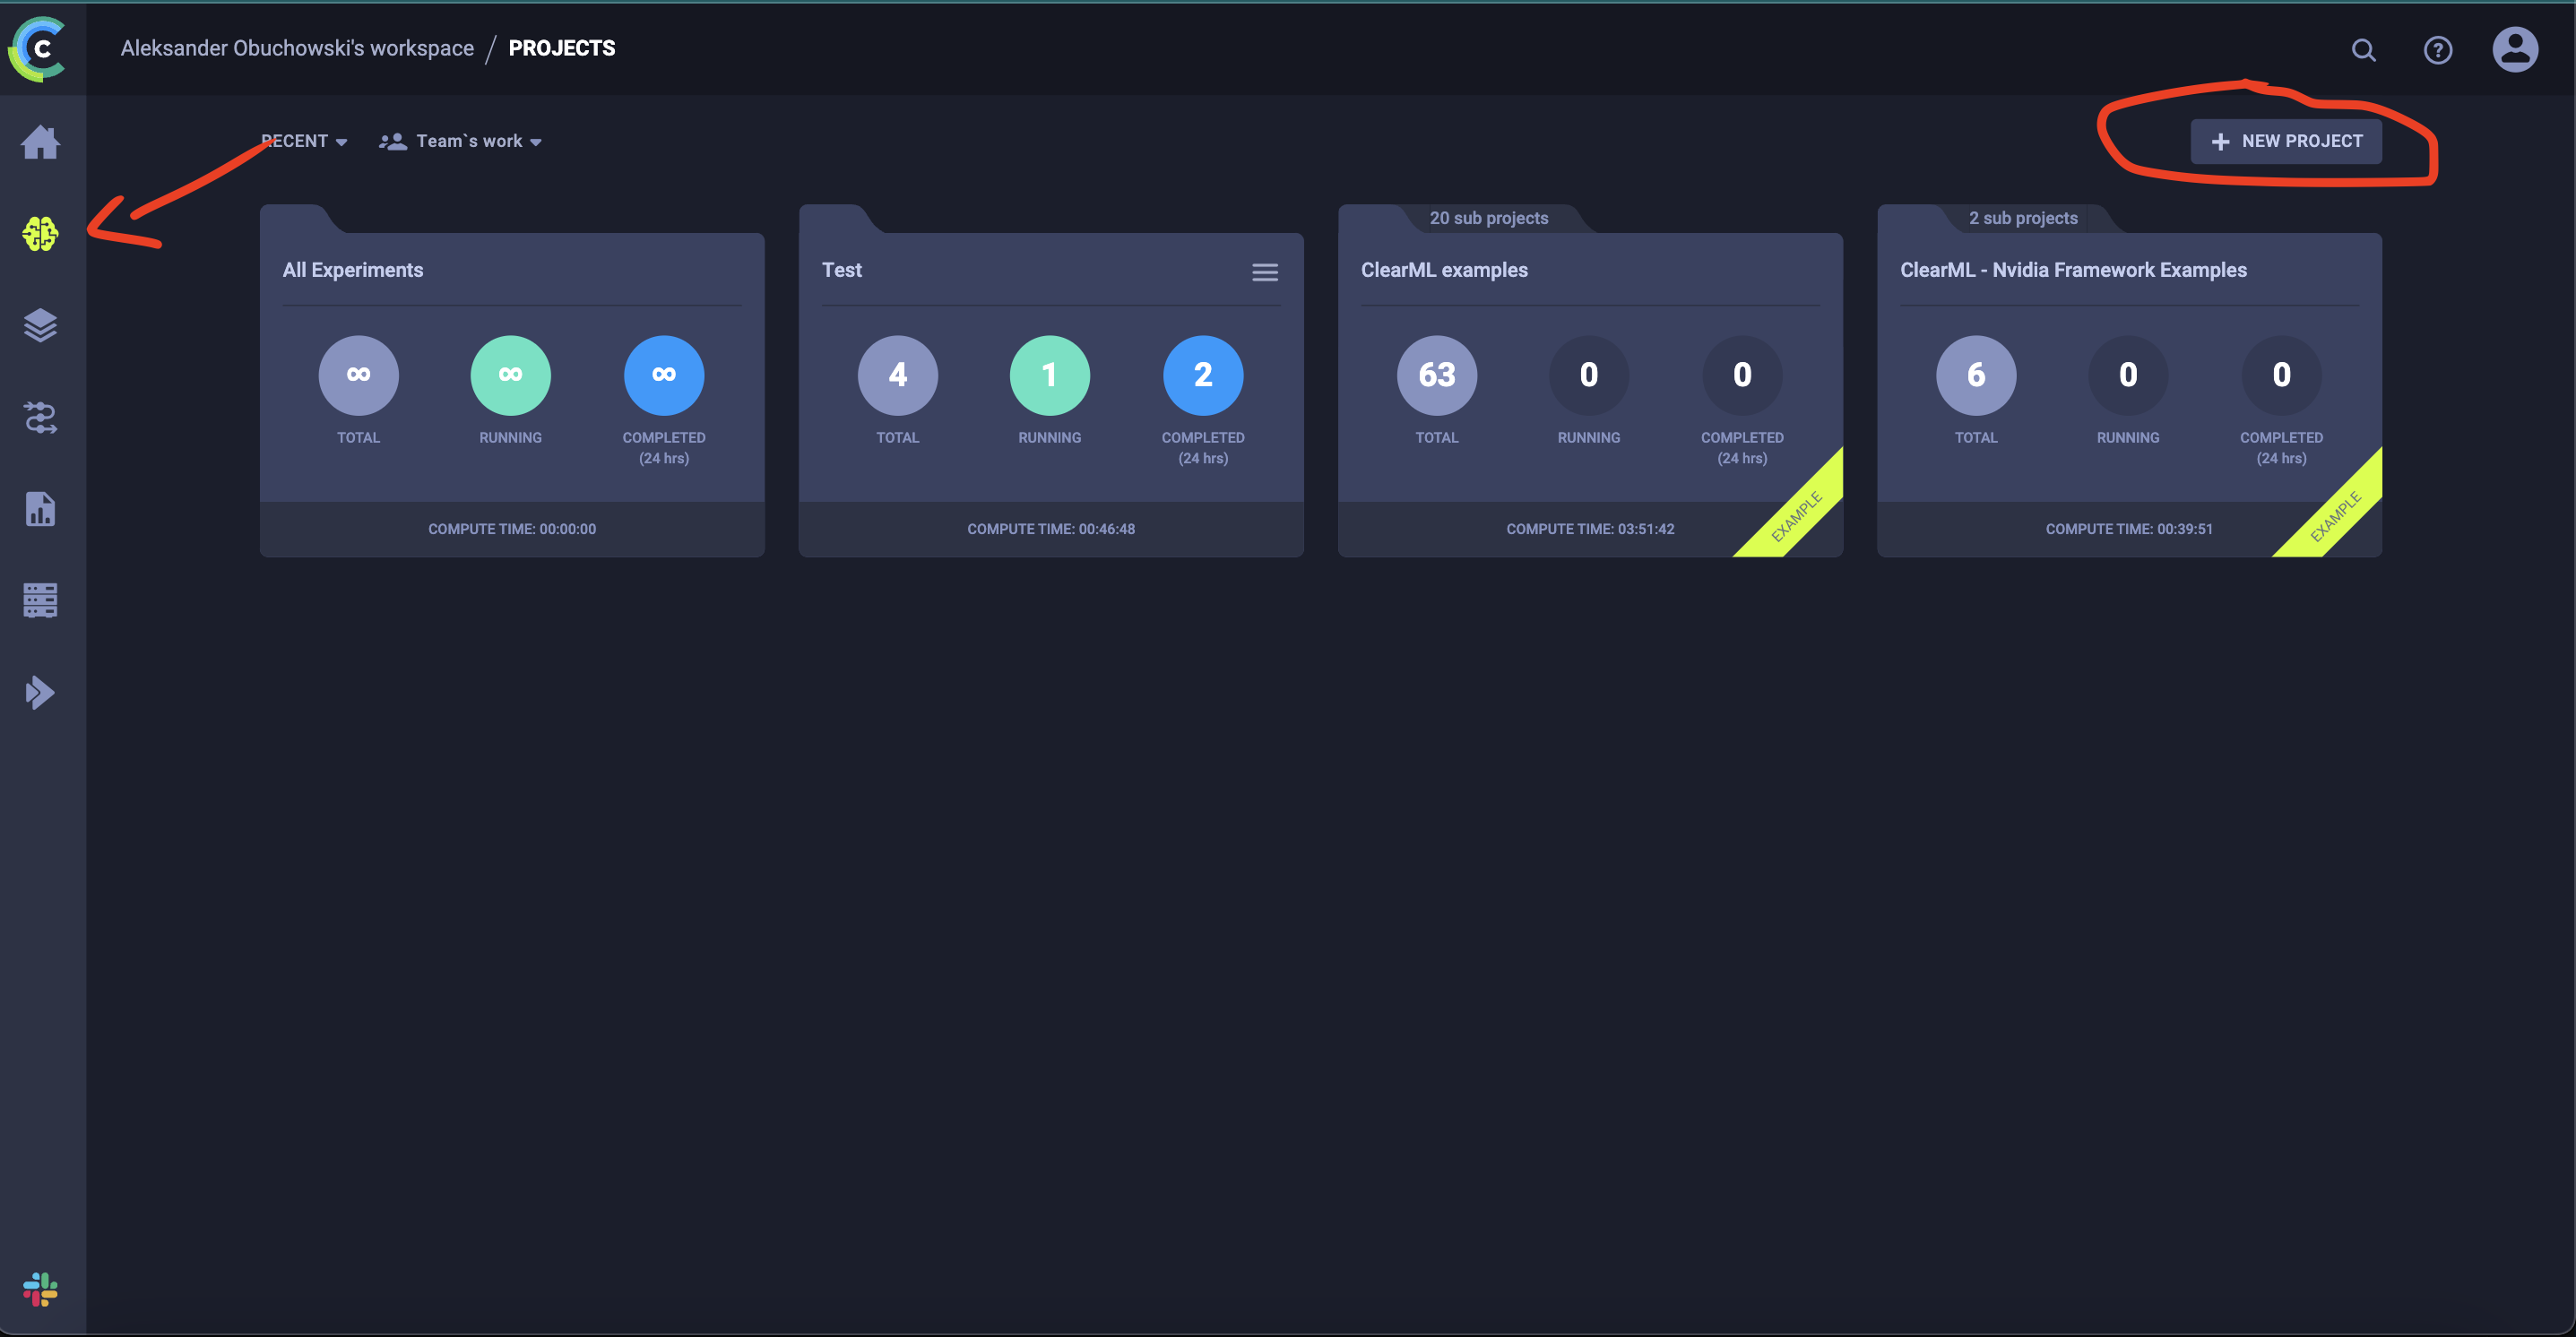

# Śledzenie eksperymentów

### Model

Tworzymy zwyczajny model w pytorchu

In [ ]:
import os
import torch
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

from torchvision.datasets.mnist import MNIST
from torchvision import transforms


class LitClassifier(pl.LightningModule):
    def __init__(self, hidden_dim=128, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters() # <- zapisujemy hiperparametry (wszystkie zmienne z funkcji init)

        self.l1 = torch.nn.Linear(28 * 28, self.hparams.hidden_dim) # <- możemy potem skorzystać ze zmiennej  self.hparams
        self.l2 = torch.nn.Linear(self.hparams.hidden_dim, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('valid_loss', loss)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

Ustawiamy parametry

In [ ]:
batch_size = 32
learning_rate = 0.001
hidden_dim = 100

Inicujemy zadanie - `Task` specjalny obiekt który będzie nam umożliwiać śledzenie wyników modelu, ustawiamy `project_name` na nazwe projektu który stowrzyliśmy przed chwilą i `task_name` na nazwę naszego eksperymentu

In [ ]:
!pip install clearml

  Using cached clearml-1.13.2-py2.py3-none-any.whl (1.1 MB)
  Using cached furl-2.1.3-py2.py3-none-any.whl (20 kB)
  Using cached pathlib2-2.3.7.post1-py2.py3-none-any.whl (18 kB)
  Attempting uninstall: pyjwt
    Found existing installation: PyJWT 2.3.0
    Uninstalling PyJWT-2.3.0:
      Successfully uninstalled PyJWT-2.3.0


In [ ]:
from clearml import Task

In [ ]:
task = Task.init(project_name="Test", task_name="PyTorch lightning MNIST example")

ClearML Task: created new task id=de091bfc77734113a4b89cb36821d1fd
2023-11-28 00:30:37,551 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/69f42e508fab49e694fcc4c13ec49632/experiments/de091bfc77734113a4b89cb36821d1fd/output/log


Reszta treningu przebiega tak jak dotychczach

In [ ]:
dataset = MNIST('', train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST('', train=False, download=True, transform=transforms.ToTensor())
mnist_train, mnist_val = random_split(dataset, [55000, 5000])

100%|██████████| 9912422/9912422 [00:00<00:00, 87315131.87it/s]


Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22804159.23it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw


100%|██████████| 1648877/1648877 [00:00<00:00, 44012698.69it/s]


Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19782480.55it/s]


Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



In [ ]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, num_workers=os.cpu_count())
val_loader = DataLoader(mnist_val, batch_size=batch_size, num_workers=os.cpu_count())
test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers=os.cpu_count())

In [ ]:
model = LitClassifier(hidden_dim, learning_rate)
trainer = pl.Trainer(max_epochs=5)
trainer.fit(model, train_loader, val_loader)
trainer.test(dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 78.5 K
1 | l2   | Linear | 1.0 K 
--------------------------------
79.5 K    Trainable params
0         Non-trainable params
79.5 K    Total params
0.318     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_0/checkpoints/epoch=4-step=8595.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_0/checkpoints/epoch=4-step=8595.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.327820748090744     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.327820748090744}]

Zamykamy zadanie - ważne w notebookach w lokalnym kodzie zadanie zamknie się automatycznie kiedy skrypt skończy się wykonywać

In [ ]:
task.close()

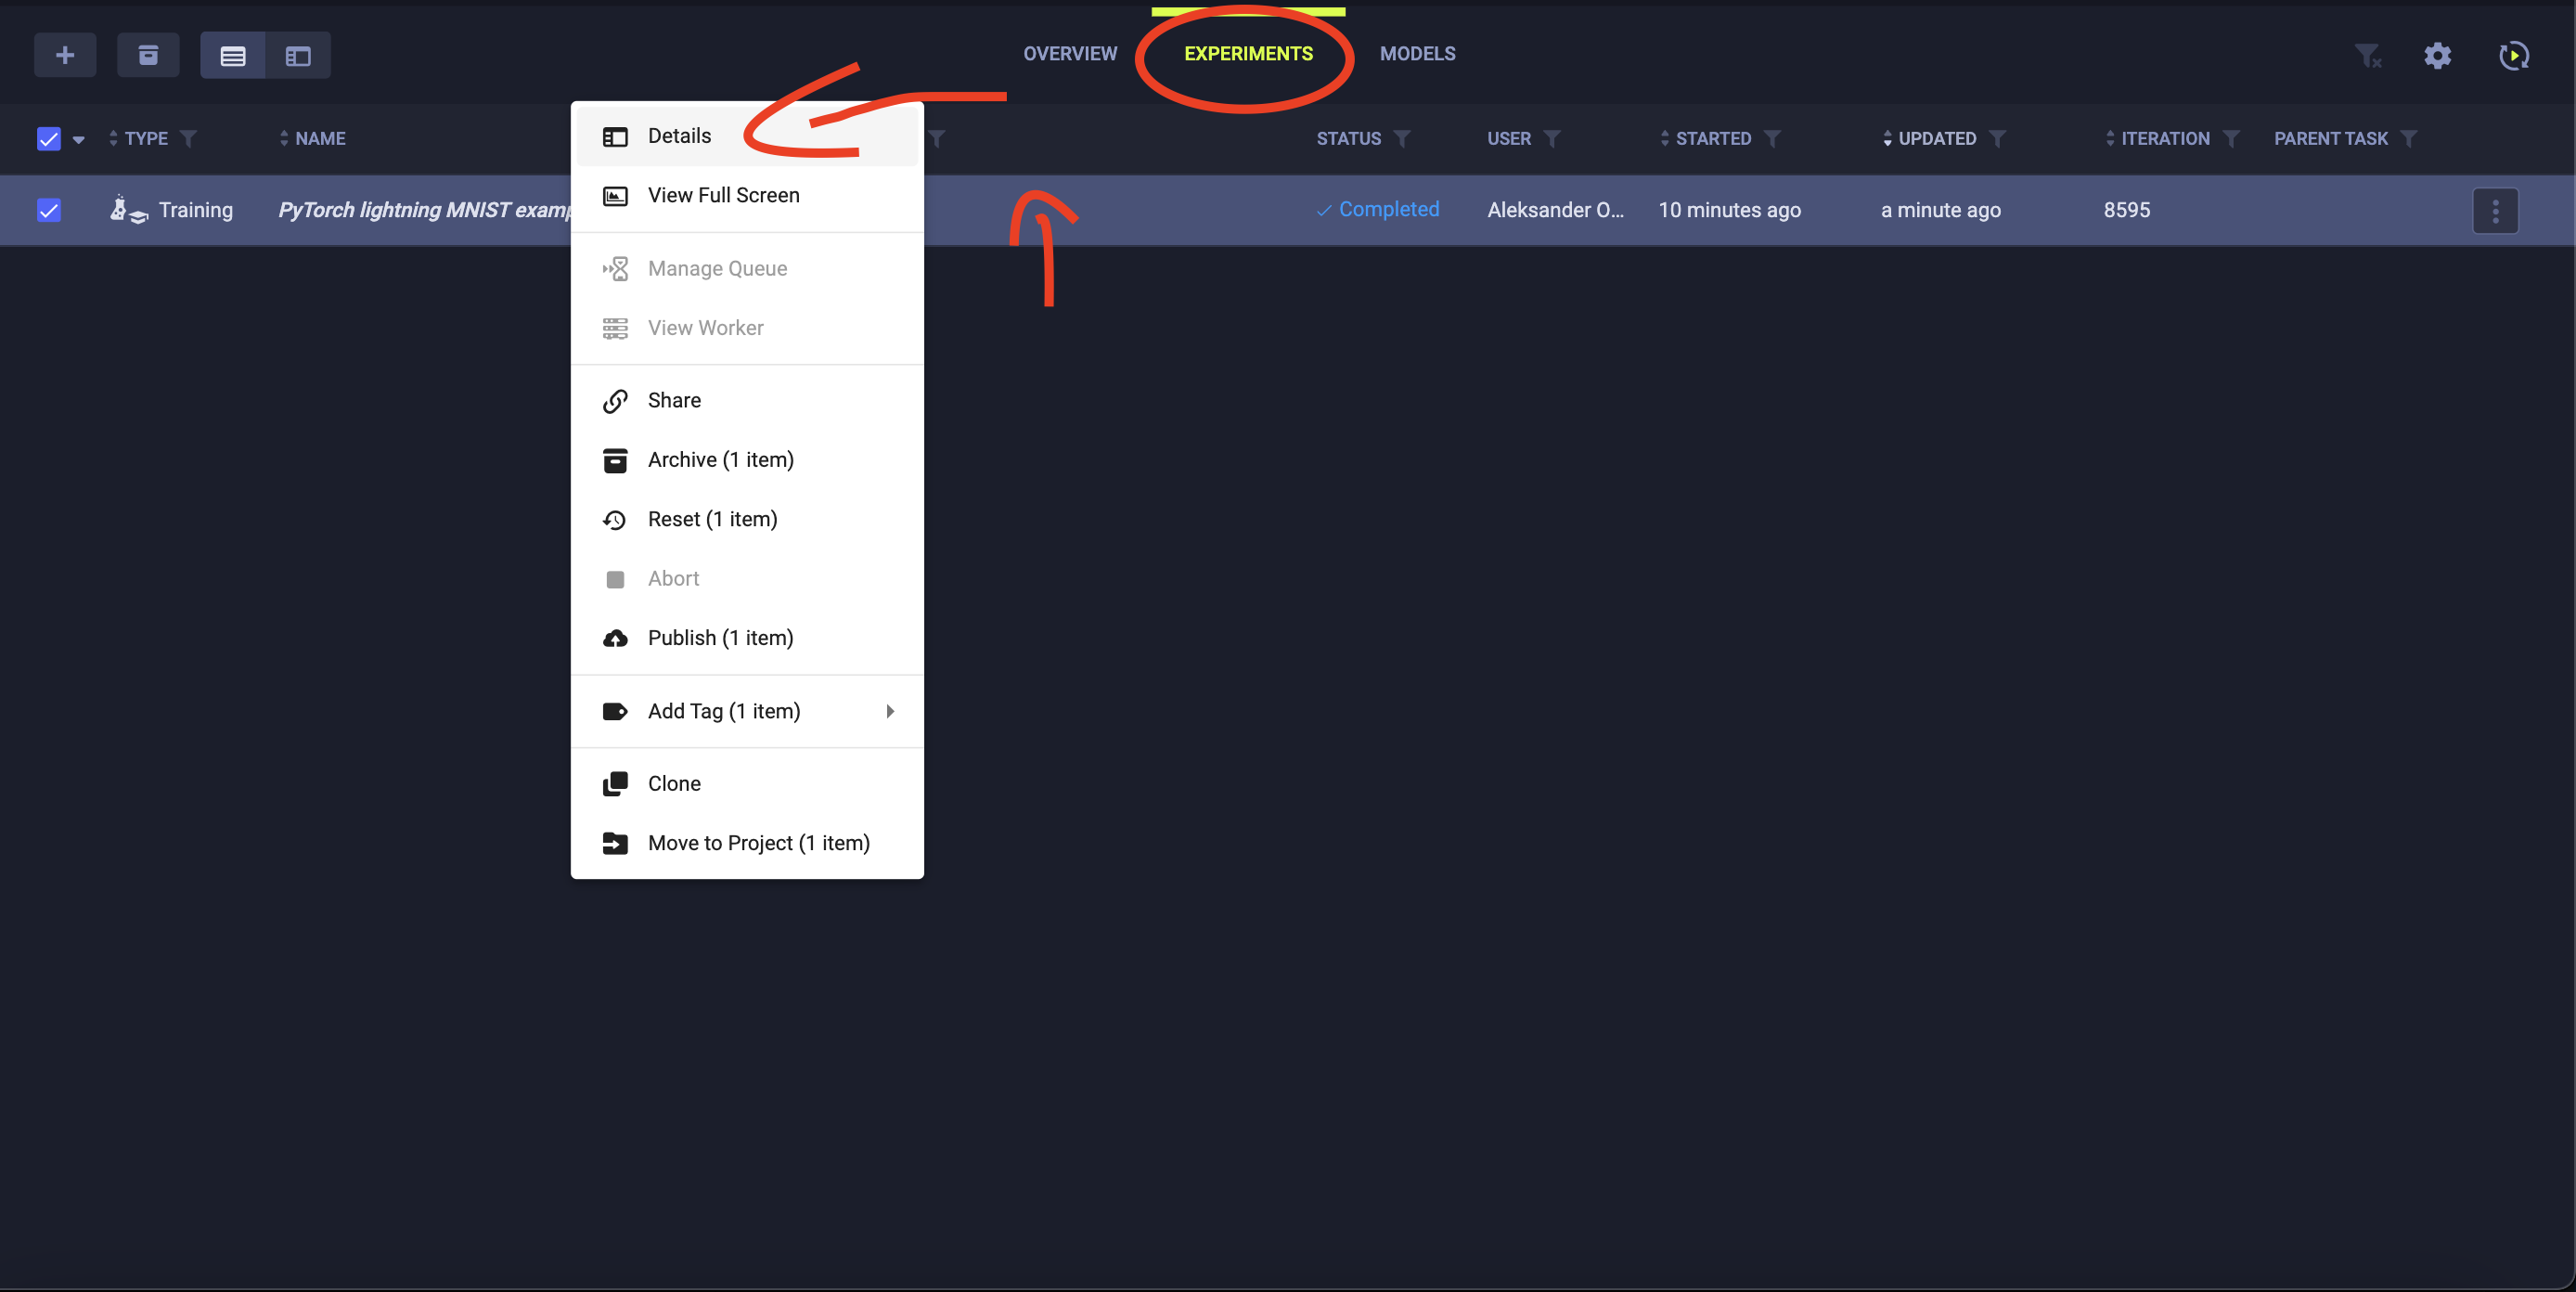

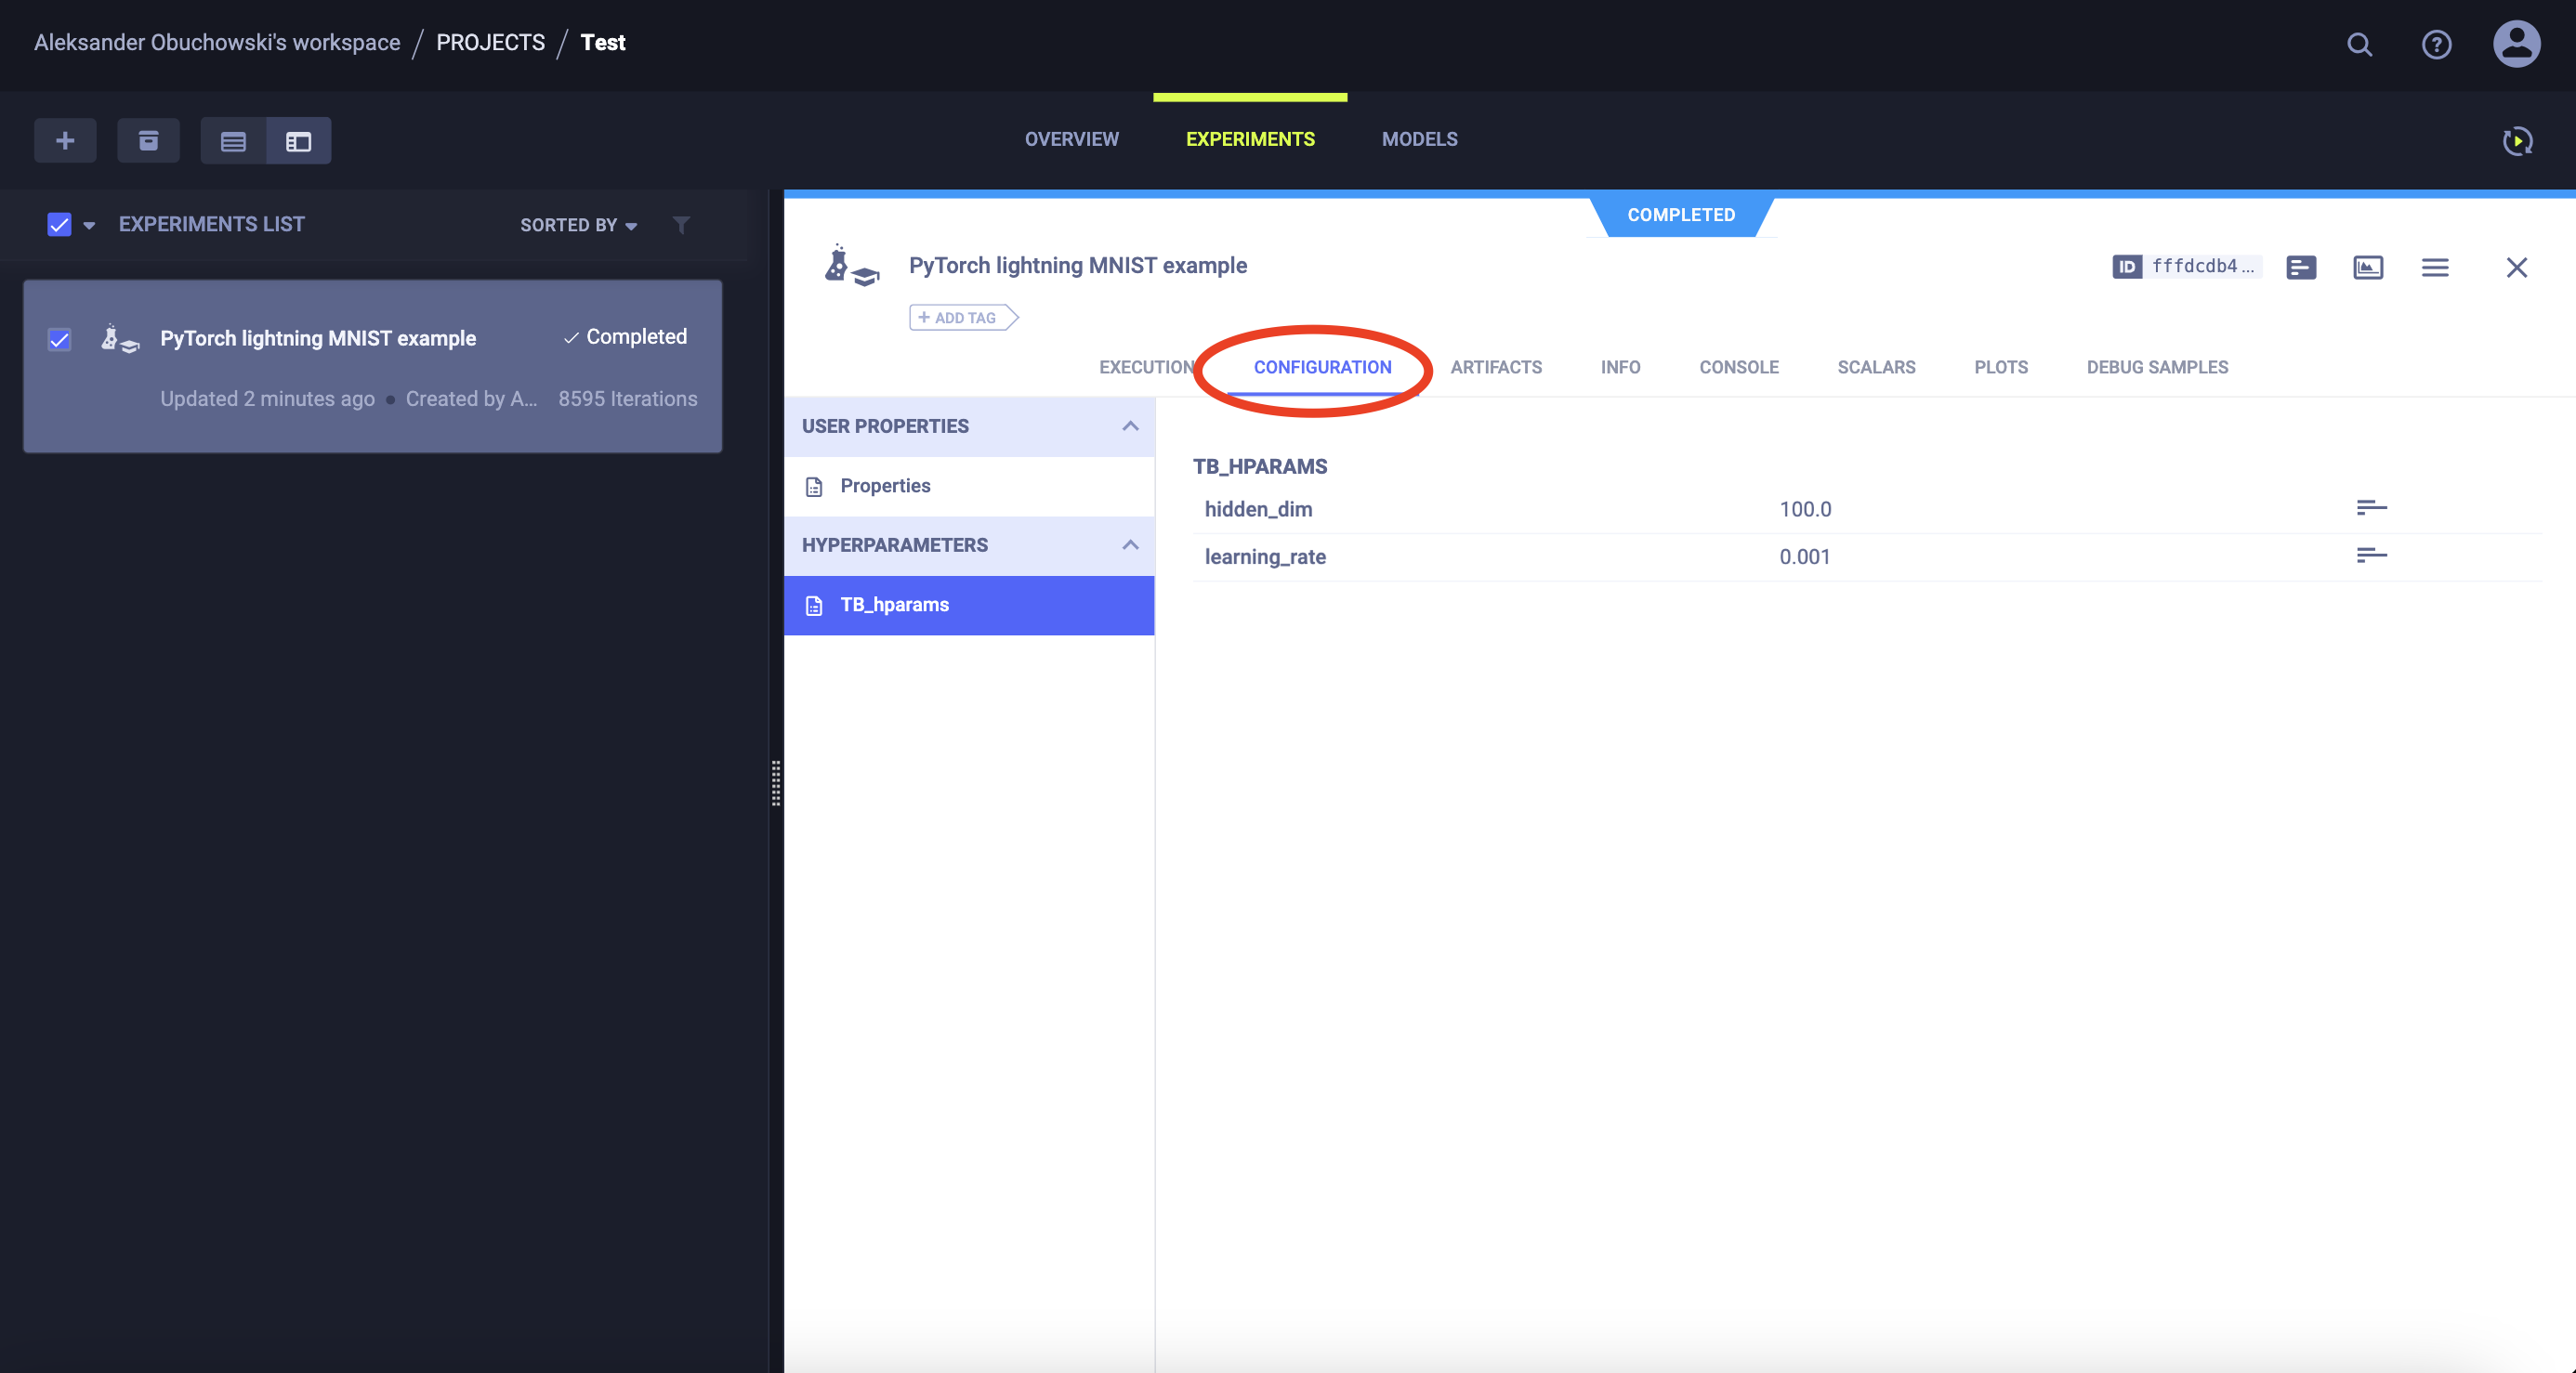

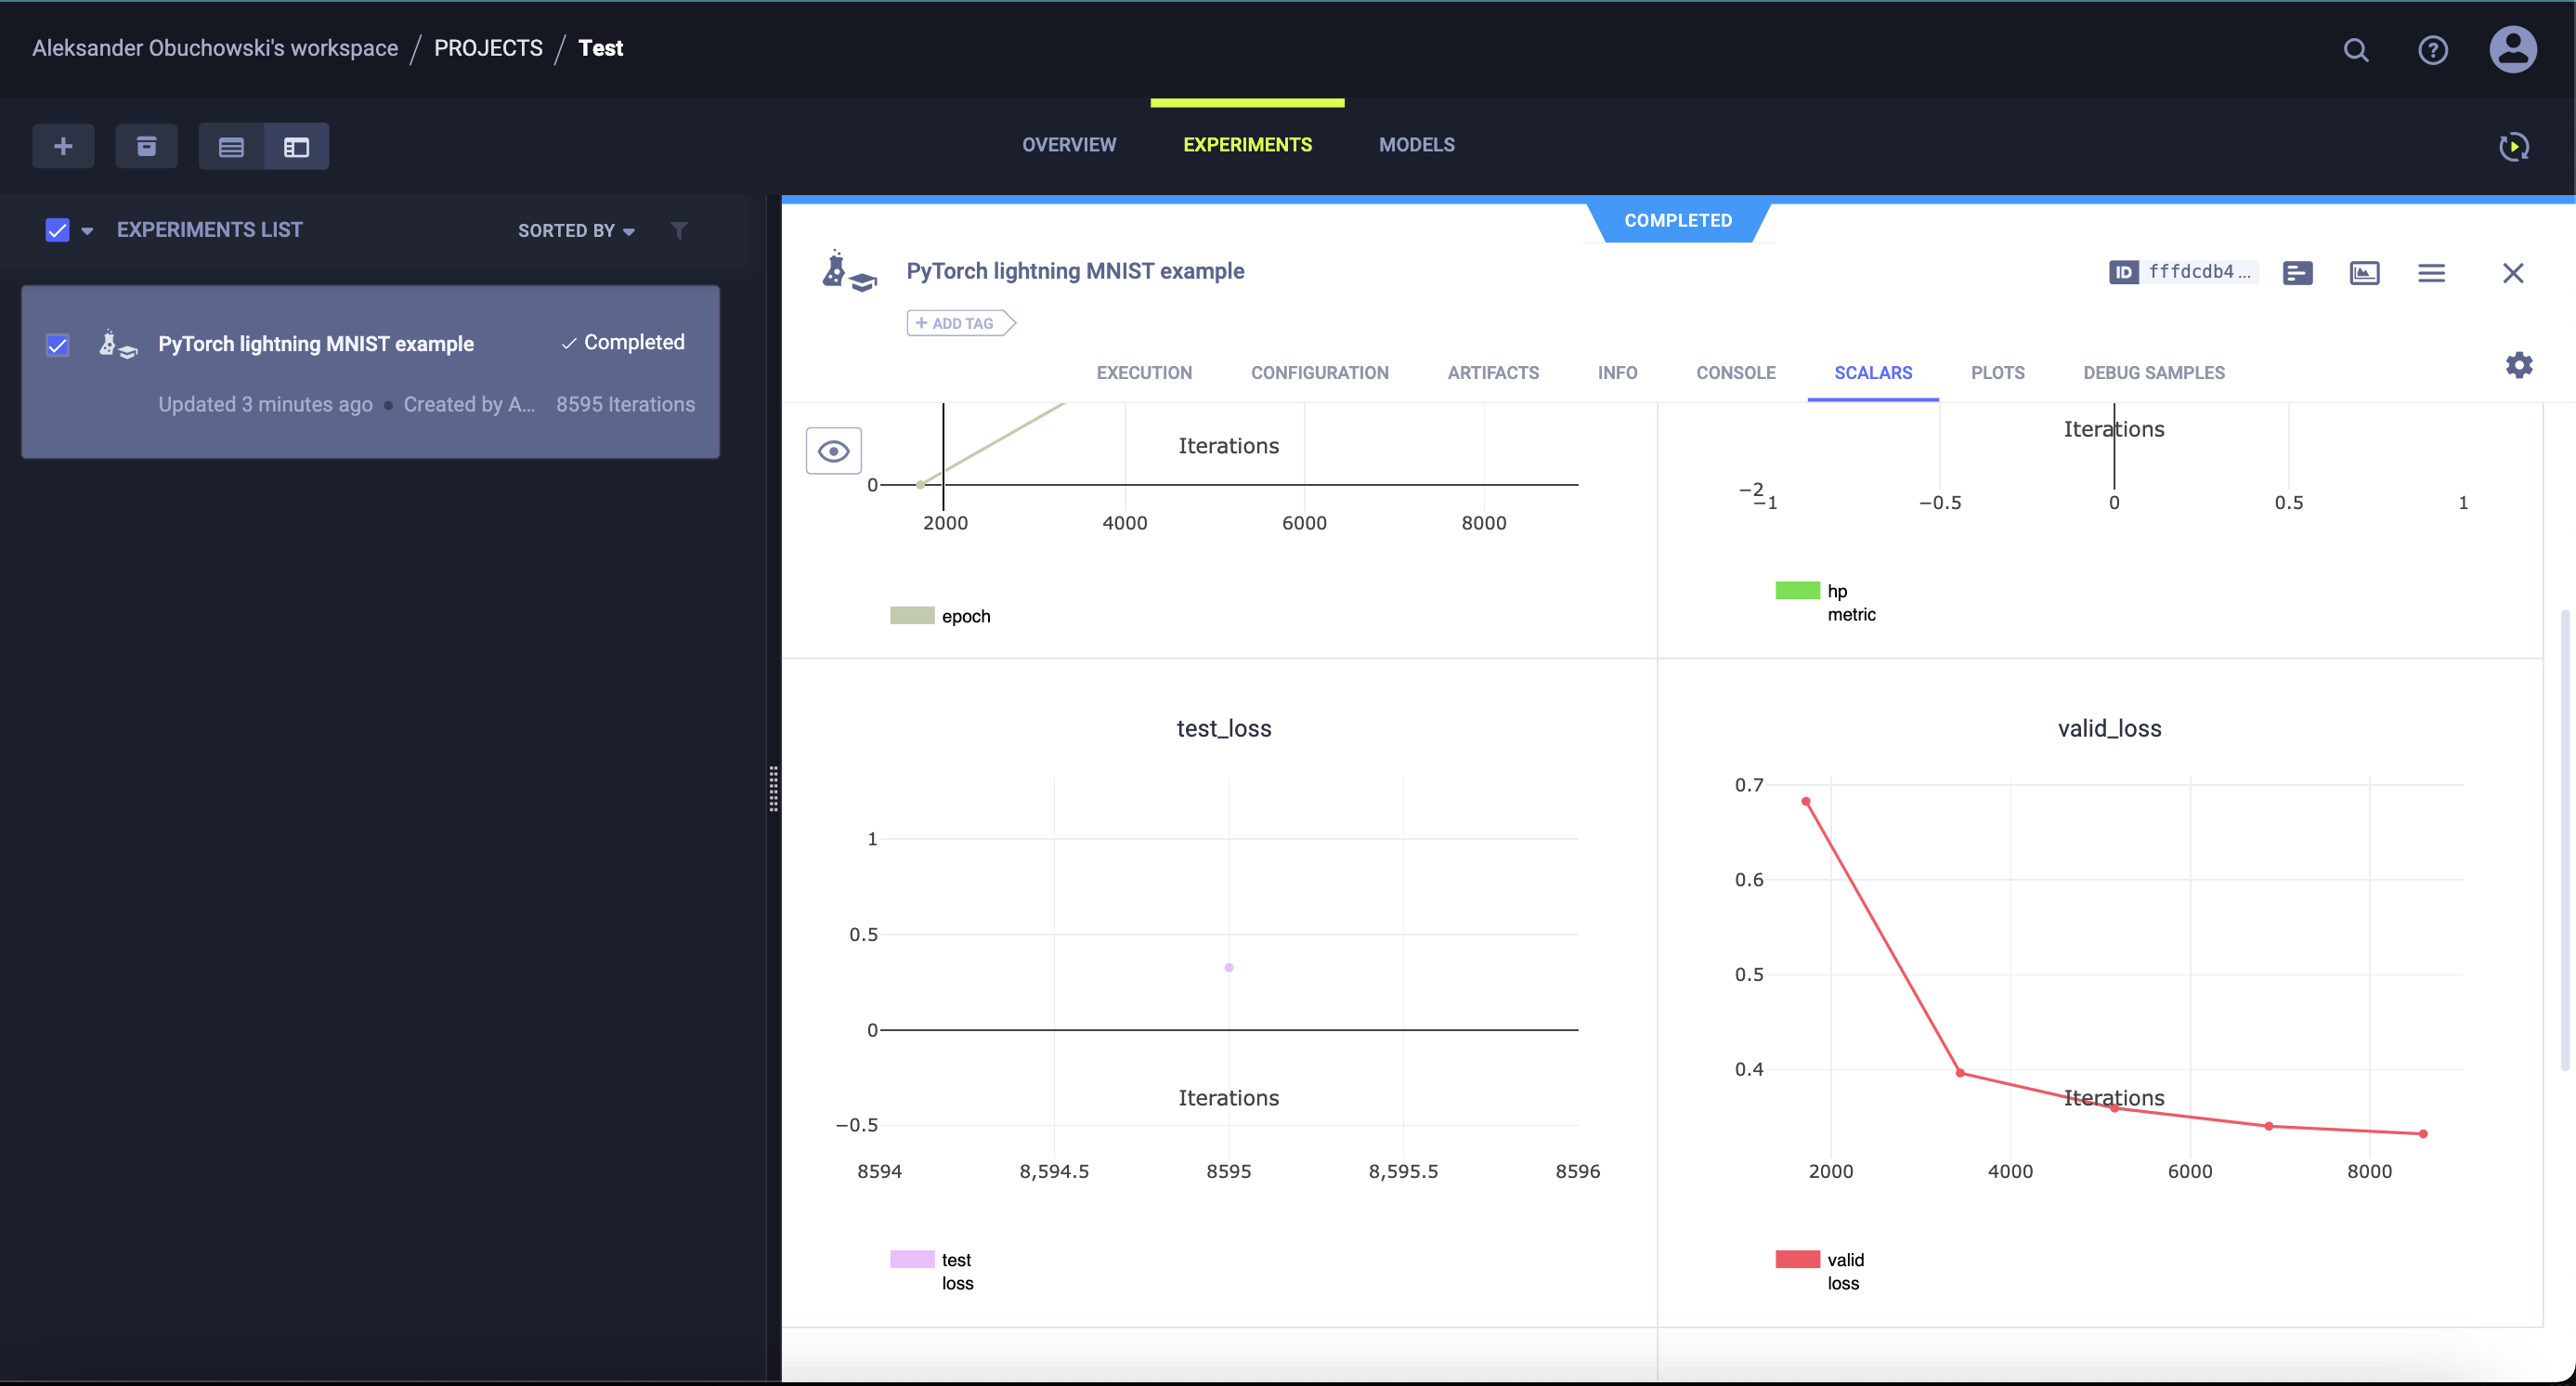

# Zadanie 1 - śledzenie dodatkowych zmiennych

Nasz eksperyment nie śledzi automatycznie wszystkich danych np. zmiennej batch_size, bo nie jest ona użyta bezpośrednio w modelu. Korzystając z poradnika https://clear.ml/docs/latest/docs/getting_started/ds/ds_second_steps, stwórz nowy eksperyment do którego przekażesz:

* batch size
* liczbę epok

Wytrenuj nowy model z innymi parametrami i porównaj dwa modele w Clear ML

In [ ]:
task = Task.init(project_name="Test", task_name="Sledzenie dodatkowych zmiennych")

ClearML Task: created new task id=11206be11ffe42c69f5216215cf504a2
ClearML results page: https://app.clear.ml/projects/69f42e508fab49e694fcc4c13ec49632/experiments/11206be11ffe42c69f5216215cf504a2/output/log


In [ ]:
params = {
    'hidden_dim': 50,
    'max_epochs': 3
}
task.connect(params)

{'hidden_dim': 50, 'max_epochs': 3}

In [ ]:
hidden_dim = params['hidden_dim']
max_epochs = params['max_epochs']

In [ ]:
dataset = MNIST('', train=True, download=True, transform=transforms.ToTensor())
mnist_test = MNIST('', train=False, download=True, transform=transforms.ToTensor())
mnist_train, mnist_val = random_split(dataset, [55000, 5000])

In [ ]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, num_workers=os.cpu_count())
val_loader = DataLoader(mnist_val, batch_size=batch_size, num_workers=os.cpu_count())
test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers=os.cpu_count())

In [ ]:
model = LitClassifier(hidden_dim, learning_rate)
trainer = pl.Trainer(max_epochs=max_epochs)
trainer.fit(model, train_loader, val_loader)
trainer.test(dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 39.2 K
1 | l2   | Linear | 510   
--------------------------------
39.8 K    Trainable params
0         Non-trainable params
39.8 K    Total params
0.159     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_28/checkpoints/epoch=2-step=5157.ckpt
Connecting multiple input models with the same name: `epoch=2-step=5157`. This might result in the wrong model being used when executing remotely
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_28/checkpo

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5888654589653015     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5888654589653015}]

In [ ]:
task.close()

# Zadanie 2 - wyszukiwanie hiperparametrów

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.9 MB/s eta 0:00:00


In [ ]:
from clearml.automation import UniformParameterRange, UniformIntegerParameterRange
from clearml.automation import HyperParameterOptimizer
from clearml.automation.optuna import OptimizerOptuna

In [ ]:
trainer.test(dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_1/checkpoints/epoch=4-step=8595.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_1/checkpoints/epoch=4-step=8595.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.327820748090744     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.327820748090744}]

In [ ]:
task = Task.init(
    project_name='Hyper-Parameter Optimization',
    task_name='Automatic Hyper-Parameter Optimization',
    task_type=Task.TaskTypes.optimizer,
    reuse_last_task_id=False
)

In [ ]:
task.close()

In [ ]:
import optuna

def objective(trial):

    task = Task.init(
      project_name='Test',
      task_name='Automatic Hyper-Parameter Optimization',
      task_type=Task.TaskTypes.optimizer,
      reuse_last_task_id=False
    )

    # zaninijalizuj zmienną hidden_dim używając optuna.suggest
    hidden_dim = trial.suggest_int('hidden_dim', 50, 100)

    # zainincjalizuj dataset, dataloader i model
    dataset = MNIST('', train=True, download=True, transform=transforms.ToTensor())
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=os.cpu_count())
    model = LitClassifier(hidden_dim, learning_rate)

    # wytrenuj model
    trainer = pl.Trainer(max_epochs=5)
    trainer.fit(model, dataloader)

    # sprawdź wyniki modelu na zbiorze testowym używając funkcji trainer.test
    test_result = trainer.test(dataloaders=test_loader)

    # zamknij zadanie
    task.close()

    # zwróć pojedyńczą wartość - test_loss dla zbioru testowego
    return test_result[0]['test_loss']

In [ ]:
study = optuna.create_study()
study.optimize(objective, n_trials=10)

study.best_params

[I 2023-11-28 01:45:26,703] A new study created in memory with name: no-name-5e453a8e-0a9e-40c8-8d0f-87fe46629a64


ClearML Task: created new task id=5e3ecbc90aba4dae8c5e03ebac8e087b
ClearML results page: https://app.clear.ml/projects/69f42e508fab49e694fcc4c13ec49632/experiments/5e3ecbc90aba4dae8c5e03ebac8e087b/output/log


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 57.3 K
1 | l2   | Linear | 740   
--------------------------------
58.0 K    Trainable params
0         Non-trainable params
58.0 K    Total params
0.232     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_17/checkpoints/epoch=4-step=9375.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_17/checkpoints/epoch=4-step=9375.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5501783490180969     │
└───────────────────────────┴───────────────────────────┘

[I 2023-11-28 01:47:41,082] Trial 0 finished with value: 0.5501783490180969 and parameters: {'hidden_dim': 73}. Best is trial 0 with value: 0.5501783490180969.


ClearML Task: created new task id=d1f7ee42351645ce81017684e1ef5d53
ClearML results page: https://app.clear.ml/projects/69f42e508fab49e694fcc4c13ec49632/experiments/d1f7ee42351645ce81017684e1ef5d53/output/log


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 62.0 K
1 | l2   | Linear | 800   
--------------------------------
62.8 K    Trainable params
0         Non-trainable params
62.8 K    Total params
0.251     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_18/checkpoints/epoch=4-step=9375.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_18/checkpoints/epoch=4-step=9375.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5295370817184448     │
└───────────────────────────┴───────────────────────────┘

[I 2023-11-28 01:49:25,437] Trial 1 finished with value: 0.5295370817184448 and parameters: {'hidden_dim': 79}. Best is trial 1 with value: 0.5295370817184448.


ClearML Task: created new task id=d1ca58645f9f4a0696793dcaf9037f79
ClearML results page: https://app.clear.ml/projects/69f42e508fab49e694fcc4c13ec49632/experiments/d1ca58645f9f4a0696793dcaf9037f79/output/log


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 62.8 K
1 | l2   | Linear | 810   
--------------------------------
63.6 K    Trainable params
0         Non-trainable params
63.6 K    Total params
0.254     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_19/checkpoints/epoch=4-step=9375.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_19/checkpoints/epoch=4-step=9375.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3321959674358368     │
└───────────────────────────┴───────────────────────────┘

[I 2023-11-28 01:51:20,086] Trial 2 finished with value: 0.3321959674358368 and parameters: {'hidden_dim': 80}. Best is trial 2 with value: 0.3321959674358368.


ClearML Task: created new task id=a450cfcb138642649047bea1a882613f
ClearML results page: https://app.clear.ml/projects/69f42e508fab49e694fcc4c13ec49632/experiments/a450cfcb138642649047bea1a882613f/output/log


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 44.0 K
1 | l2   | Linear | 570   
--------------------------------
44.5 K    Trainable params
0         Non-trainable params
44.5 K    Total params
0.178     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_20/checkpoints/epoch=4-step=9375.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_20/checkpoints/epoch=4-step=9375.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.7765445709228516     │
└───────────────────────────┴───────────────────────────┘

[I 2023-11-28 01:53:04,621] Trial 3 finished with value: 0.7765445709228516 and parameters: {'hidden_dim': 56}. Best is trial 2 with value: 0.3321959674358368.


ClearML Task: created new task id=871c89e0d7064969bf641865b032377a
ClearML results page: https://app.clear.ml/projects/69f42e508fab49e694fcc4c13ec49632/experiments/871c89e0d7064969bf641865b032377a/output/log


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 58.1 K
1 | l2   | Linear | 750   
--------------------------------
58.8 K    Trainable params
0         Non-trainable params
58.8 K    Total params
0.235     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_21/checkpoints/epoch=4-step=9375.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_21/checkpoints/epoch=4-step=9375.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.0278438329696655     │
└───────────────────────────┴───────────────────────────┘

[I 2023-11-28 01:54:48,991] Trial 4 finished with value: 1.0278438329696655 and parameters: {'hidden_dim': 74}. Best is trial 2 with value: 0.3321959674358368.


ClearML Task: created new task id=4e0f15fafa554df8ad67debc3c7ccb6f
ClearML results page: https://app.clear.ml/projects/69f42e508fab49e694fcc4c13ec49632/experiments/4e0f15fafa554df8ad67debc3c7ccb6f/output/log


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 59.7 K
1 | l2   | Linear | 770   
--------------------------------
60.4 K    Trainable params
0         Non-trainable params
60.4 K    Total params
0.242     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_22/checkpoints/epoch=4-step=9375.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_22/checkpoints/epoch=4-step=9375.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.3011002540588379     │
└───────────────────────────┴───────────────────────────┘

[I 2023-11-28 01:56:33,890] Trial 5 finished with value: 0.3011002540588379 and parameters: {'hidden_dim': 76}. Best is trial 5 with value: 0.3011002540588379.


ClearML Task: created new task id=d76bc670c5e440dab743a9f2853b8bd9
ClearML results page: https://app.clear.ml/projects/69f42e508fab49e694fcc4c13ec49632/experiments/d76bc670c5e440dab743a9f2853b8bd9/output/log


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 69.1 K
1 | l2   | Linear | 890   
--------------------------------
70.0 K    Trainable params
0         Non-trainable params
70.0 K    Total params
0.280     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_23/checkpoints/epoch=4-step=9375.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_23/checkpoints/epoch=4-step=9375.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.53152996301651      │
└───────────────────────────┴───────────────────────────┘

[I 2023-11-28 01:58:18,302] Trial 6 finished with value: 0.53152996301651 and parameters: {'hidden_dim': 88}. Best is trial 5 with value: 0.3011002540588379.


ClearML Task: created new task id=786aaf85fb4b428eaf1216cc6edf4861
ClearML results page: https://app.clear.ml/projects/69f42e508fab49e694fcc4c13ec49632/experiments/786aaf85fb4b428eaf1216cc6edf4861/output/log


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 73.8 K
1 | l2   | Linear | 950   
--------------------------------
74.7 K    Trainable params
0         Non-trainable params
74.7 K    Total params
0.299     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_24/checkpoints/epoch=4-step=9375.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_24/checkpoints/epoch=4-step=9375.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.819611132144928     │
└───────────────────────────┴───────────────────────────┘

[I 2023-11-28 02:00:08,095] Trial 7 finished with value: 0.819611132144928 and parameters: {'hidden_dim': 94}. Best is trial 5 with value: 0.3011002540588379.


ClearML Task: created new task id=5cd8f632ca0343aa8a91835d65752f84
ClearML results page: https://app.clear.ml/projects/69f42e508fab49e694fcc4c13ec49632/experiments/5cd8f632ca0343aa8a91835d65752f84/output/log


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 65.2 K
1 | l2   | Linear | 840   
--------------------------------
66.0 K    Trainable params
0         Non-trainable params
66.0 K    Total params
0.264     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_25/checkpoints/epoch=4-step=9375.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_25/checkpoints/epoch=4-step=9375.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5244439840316772     │
└───────────────────────────┴───────────────────────────┘

[I 2023-11-28 02:02:02,435] Trial 8 finished with value: 0.5244439840316772 and parameters: {'hidden_dim': 83}. Best is trial 5 with value: 0.3011002540588379.


ClearML Task: created new task id=91312e498f174f04b00c26831575c166
ClearML results page: https://app.clear.ml/projects/69f42e508fab49e694fcc4c13ec49632/experiments/91312e498f174f04b00c26831575c166/output/log


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: PossibleUserWarning:

You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 56.5 K
1 | l2   | Linear | 730   
--------------------------------
57.2 K    Trainable params
0         Non-trainable params
57.2 K    Total params
0.229     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: UserWarning:

`.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/lightning_logs/version_26/checkpoints/epoch=4-step=9375.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/lightning_logs/version_26/checkpoints/epoch=4-step=9375.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5172927379608154     │
└───────────────────────────┴───────────────────────────┘

[I 2023-11-28 02:03:56,742] Trial 9 finished with value: 0.5172927379608154 and parameters: {'hidden_dim': 72}. Best is trial 5 with value: 0.3011002540588379.


{'hidden_dim': 76}

In [ ]:
task.close()